<a href="https://colab.research.google.com/github/monmon2003/PyTorch/blob/main/Pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow
Let's explore an example PyTorch end-to-end workflow.

In [ ]:
what_we_are_covering = {1:"data(prepare and load)",
                        2: "build model",
                        3:"fitting the model to data (training)",
                        4:"making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"
                        }


In [ ]:
import torch
from torch import nn ## nn contains all the building blocks of neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

## Data Preparation and Loading
Data can be almost anything..  in machine learning.
* Excel Spreadsheet
* Images of any kind
* Videos
* Audio like songs or podcast
* DNA
* Text
ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [ ]:
# Create *Known* parameters
weight = 0.7
bias = 0.3
# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
X.shape

torch.Size([50, 1])

In [ ]:
len(X),len(y)

(50, 50)

### Splitting data into training and test sets

In [ ]:
# create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions

  """
  plt.figure(figsize=(10,7))

  # Plot training data in yellow
  plt.scatter(train_data, train_labels, c='y', s=20, label="Training Data")

  # Plot test data in blue
  plt.scatter(test_data, test_labels, c='b', s=20, label="Testing Data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictionz if they exist
    plt.scatter(test_data, predictions, c='r', s=20, label="Predictions")
  plt.legend(prop={"size":14})

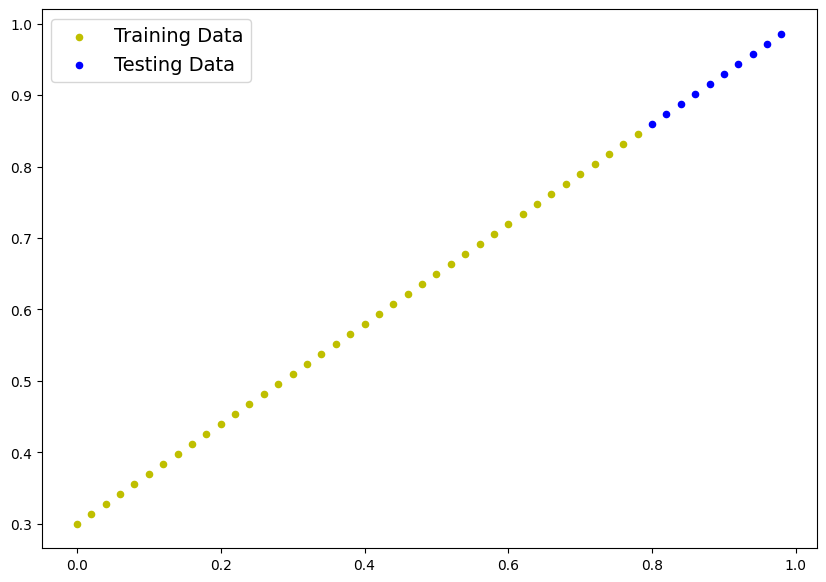

In [ ]:
plot_predictions()

## 2. Build the Model

In [ ]:
# Create linear regression model class

# almost everything in pytorch inherits from nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float32))
    self.bias = nn.Parameter(torch.randn(1,
                                        requires_grad=True,
                                        dtype=torch.float32))

    # Forward method to define the computation in the model
  def forward(self,x: torch.Tensor) -> torch.Tensor:
      return self.weights * x + self.bias



## Checking the contents of our PyTorch model
so we can check our model parameters or what's inside our model using .parameters()

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making predictions using `torch.inference_mode()`
To check our model's predicitve power, let's see how well it predicts `y_test` based on `x_test`. When we pass data through our model, it's going to run it through the `forward()` method.

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can do the same thing with no_grad() but inference_mode() is better
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

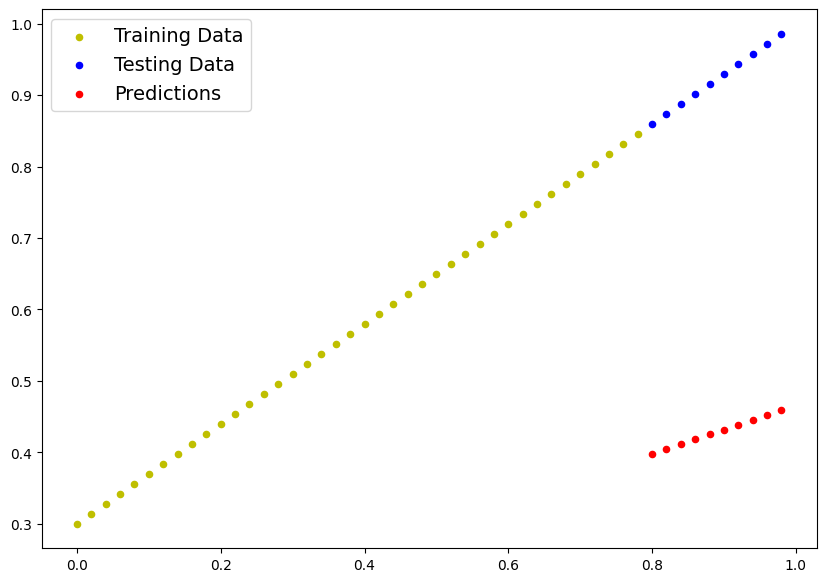

In [ ]:
plot_predictions(predictions=y_preds)

### 3. Train Model

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop) in Python

A couple of things we need in a training loop:

1.   Loop through the data
2.   Forward pass ( this involves data moving through our model's `forward()` functions) to make predcitions on data - also  called forward propagation
3.   Calculate the loss
4.   Optimizer zero grad
5.   Loss backward - move backwards through the network to calculate the gradients of each of the parameters of the loss(**backprop**)
6.   Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)



In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data...(this is an hyperparameter)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad (zero the gradients of the optimizer because the accumulate by default)
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimzer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so ... we have to zero them in step 3 for the next iteration of the loop

  # Testing
  model_0.eval() # turns off gradient tracking (for dropout, batch-norm)
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} Loss: {loss} | Test loss: {test_loss}")
  # print out model state_dict()
  # print(model_0.state_dict())


Epoch: 0 Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Epoch: 140 Loss: 0.01071658916

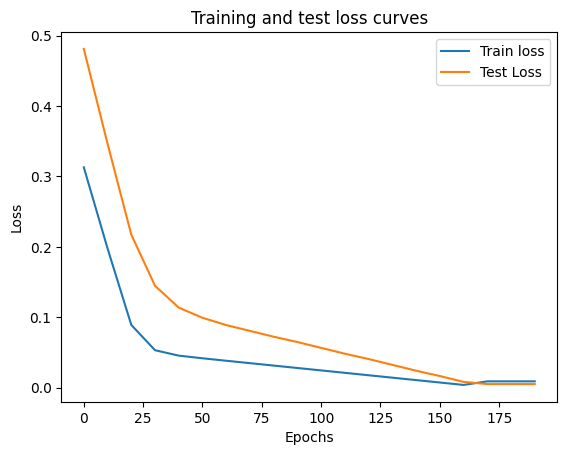

In [ ]:
import numpy as np
# plot the loss curve
plt.plot(epoch_count, torch.tensor(loss_values).detach().numpy(), label="Train loss")
plt.plot(epoch_count,test_loss_values,label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

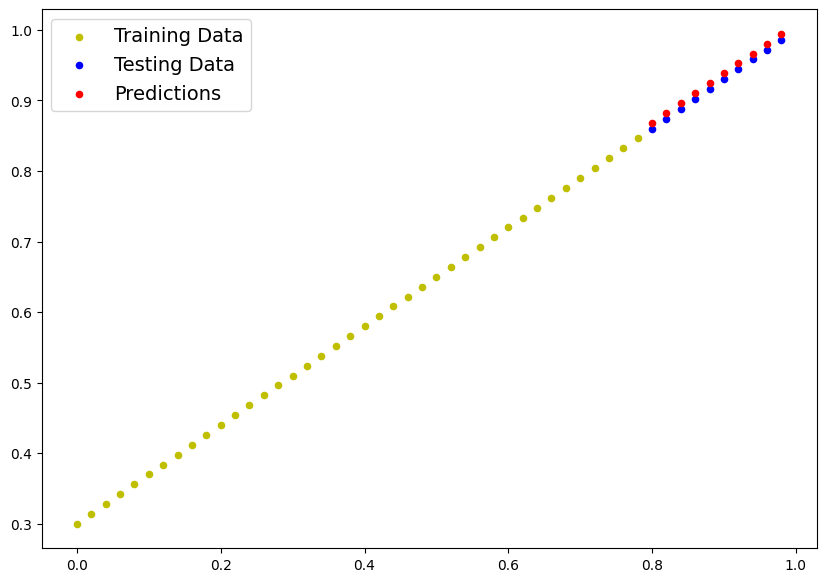

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving the Model

There are three main methods for saving and loading models



1.   `torch.save()` - allows you to save a PyTorch object in Pyhton's pickle format
2.   `torch.load()` - allows you to load a saved PyTorch object
3.   `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary



In [ ]:
# Saving the model
from pathlib import Path

# 1. Create models dictionary
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jan  8 11:27 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model and load the `state_dict()`into that.

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0 ( htis wil update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model predicitons with the original model predictions

test_pred==loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

### 1. Data

In [ ]:
torch.manual_seed(1234)
X = torch.rand((7,2))
X

tensor([[0.0290, 0.4019],
        [0.2598, 0.3666],
        [0.0583, 0.7006],
        [0.0518, 0.4681],
        [0.6738, 0.3315],
        [0.7837, 0.5631],
        [0.7749, 0.8208]])

In [ ]:
weight = torch.tensor([0.2,0.3],dtype=torch.float32)
bias = torch.tensor([0.1])
y = torch.matmul(X,weight.T)+ bias
y = torch.unsqueeze(y,1)

In [ ]:
# Splitting the dataset
train_size = int(0.7*len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train, y_train, X_test, y_test

(tensor([[0.0290, 0.4019],
         [0.2598, 0.3666],
         [0.0583, 0.7006],
         [0.0518, 0.4681]]),
 tensor([[0.2264],
         [0.2620],
         [0.3219],
         [0.2508]]),
 tensor([[0.6738, 0.3315],
         [0.7837, 0.5631],
         [0.7749, 0.8208]]),
 tensor([[0.3342],
         [0.4257],
         [0.5012]]))

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(4, 4, 3, 3)

### 2. Model

In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn((1,2)), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1), requires_grad=True)
  def forward(self, x):
    y_pred = torch.matmul(x,self.weights.T) + self.bias
    # y_pred = torch.unsqueeze(y_pred,1)
    return y_pred

In [ ]:
torch.manual_seed(42)
model = LinearModel()
print(list(model.parameters()))
model.state_dict()

[Parameter containing:
tensor([[0.3367, 0.1288]], requires_grad=True), Parameter containing:
tensor([0.2345], requires_grad=True)]


OrderedDict([('weights', tensor([[0.3367, 0.1288]])),
             ('bias', tensor([0.2345]))])

### 3. Training the model

In [ ]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Epochs
Epochs = 600

epoch_count=[]
loss_values=[]
test_loss_values=[]

for epoch in range(Epochs):
  model.train()

  #forward pass
  y_pred = model(X_train)
  # Loss
  loss = loss_fn(y_pred,y_train)

  optimizer.zero_grad()

  # Backprop
  loss.backward()

  # Update parameters
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred,y_test)

    if epoch%10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} Loss: {loss} Test Loss: {test_loss}")


Epoch: 0 Loss: 0.005154542624950409 Test Loss: 0.015497160144150257
Epoch: 10 Loss: 0.001019480754621327 Test Loss: 0.005880225915461779
Epoch: 20 Loss: 0.0009395049419254065 Test Loss: 0.005140660796314478
Epoch: 30 Loss: 0.0008770025451667607 Test Loss: 0.004771854262799025
Epoch: 40 Loss: 0.0008186946506612003 Test Loss: 0.00444513326510787
Epoch: 50 Loss: 0.0007642642594873905 Test Loss: 0.00414145877584815
Epoch: 60 Loss: 0.0007134517654776573 Test Loss: 0.0038583960849791765
Epoch: 70 Loss: 0.0006660193903371692 Test Loss: 0.003594512352719903
Epoch: 80 Loss: 0.0006217396585270762 Test Loss: 0.003348513273522258
Epoch: 90 Loss: 0.0005804049433209002 Test Loss: 0.0031191930174827576
Epoch: 100 Loss: 0.0005418180371634662 Test Loss: 0.0029054295737296343
Epoch: 110 Loss: 0.0005057975649833679 Test Loss: 0.0027061759028583765
Epoch: 120 Loss: 0.000472171523142606 Test Loss: 0.00252044596709311
Epoch: 130 Loss: 0.0004407814412843436 Test Loss: 0.0023473380133509636
Epoch: 140 Loss: 0

In [ ]:
model.state_dict()

OrderedDict([('weights', tensor([[0.2147, 0.2740]])),
             ('bias', tensor([0.1113]))])

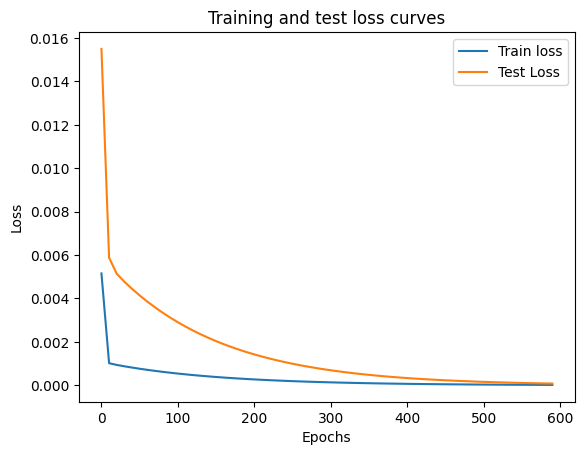

In [ ]:
import numpy as np
# plot the loss curve
plt.plot(epoch_count, torch.tensor(loss_values).detach().numpy(), label="Train loss")
plt.plot(epoch_count,test_loss_values,label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
with torch.inference_mode():
  pred = model(X_test)
print(pred)

tensor([[0.3468],
        [0.4339],
        [0.5026]])


In [ ]:
print(y_test)

tensor([[0.3342],
        [0.4257],
        [0.5012]])


In [ ]:
# Import PyTorch and matplotlib

import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

Create device-agnostic code.

This means if we've got access to GPU, our code will use it. If no GPU is available, the code will default to using CPU.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Data

In [ ]:
weight = 0.6
bias = 0.2

start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2120],
         [0.2240],
         [0.2360],
         [0.2480],
         [0.2600],
         [0.2720],
         [0.2840],
         [0.2960],
         [0.3080]]))

In [ ]:
# Split Data
train_split = int(0.8*len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

X_train, y_train, X_test, y_test

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800]]),
 tensor([[0.2000],
         [0.2120],
         [0.2240],
         [0.2360],
         [0.2480],
         [0.2600],
         [0.2720],
         [0.2840],
         [0.2960],
         [0.3080],
         [0.3200],
         [0.3320],
         [

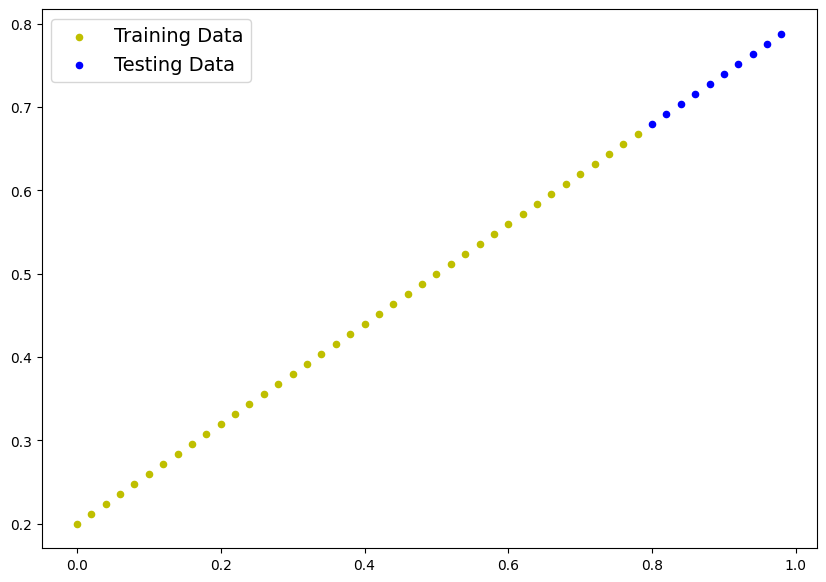

In [ ]:
plot_predictions(X_train,y_train,X_test,y_test)

In [ ]:
class LinearModel2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model paramters
    self.linear_layer = nn.Linear(in_features=1,out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearModel2()
model_1, model_1.state_dict()

(LinearModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

In [ ]:
# Loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)
epochs=200

# Put data on the target device (Data agnostic code)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred=model_1(X_train)

  # 2. Calculate the loss
  loss=loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backprop
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss=loss_fn(test_pred,y_test)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")




Epoch: 0 | Loss: 0.6941779255867004 | Test loss: 0.7629762887954712
Epoch: 10 | Loss: 0.5789680480957031 | Test loss: 0.6282663941383362
Epoch: 20 | Loss: 0.4637582004070282 | Test loss: 0.49355655908584595
Epoch: 30 | Loss: 0.3485483229160309 | Test loss: 0.3588466942310333
Epoch: 40 | Loss: 0.23333846032619476 | Test loss: 0.22413687407970428
Epoch: 50 | Loss: 0.11812856048345566 | Test loss: 0.08942705392837524
Epoch: 60 | Loss: 0.014664086513221264 | Test loss: 0.027661234140396118
Epoch: 70 | Loss: 0.010410388931632042 | Test loss: 0.0235457606613636
Epoch: 80 | Loss: 0.006971580442041159 | Test loss: 0.015273267403244972
Epoch: 90 | Loss: 0.0035398409236222506 | Test loss: 0.007687687873840332
Epoch: 100 | Loss: 0.0036876804661005735 | Test loss: 0.012758738361299038
Epoch: 110 | Loss: 0.0036876804661005735 | Test loss: 0.012758738361299038
Epoch: 120 | Loss: 0.0036876804661005735 | Test loss: 0.012758738361299038
Epoch: 130 | Loss: 0.0036876804661005735 | Test loss: 0.0127587383

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5940]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2060], device='cuda:0'))])

In [ ]:
model_1.eval()
with torch.inference_mode():
  pred=model_1(X_test)
pred

tensor([[0.6812],
        [0.6931],
        [0.7050],
        [0.7169],
        [0.7288],
        [0.7407],
        [0.7525],
        [0.7644],
        [0.7763],
        [0.7882]], device='cuda:0')

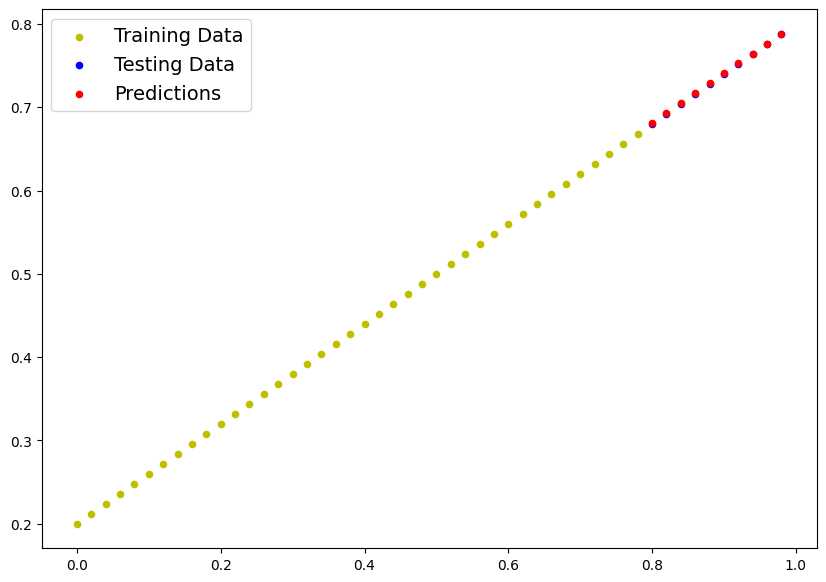

In [ ]:
plot_predictions(X_train.cpu(),y_train.cpu(),X_test.cpu(),y_test.cpu(),predictions=pred.cpu())

### Saving and loading model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME= "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Loading the model

loaded_model_1 = LinearModel2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearModel2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

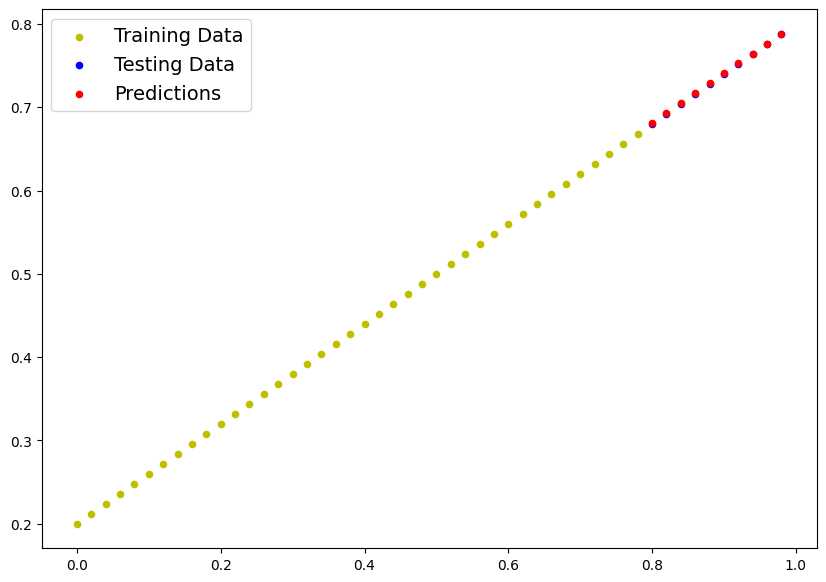

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_pred = loaded_model_1(X_test)
plot_predictions(X_train.cpu(),y_train.cpu(),X_test.cpu(),y_test.cpu(),predictions=loaded_pred.cpu())